In [3]:
# Data Manipulation Modules
import pandas as pd
import numpy as np
import scipy as sp
import numpy as np
import math 
import scipy.stats as stats
import fancyimpute 
from collections import Counter

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as ms

# Machine Learning Modeling and Cross-Validation/Accuracy 
import sklearn

random_state = 1

# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## Model Evaluation Prodecedure

The evaluation process for seeing how accurate my predictions are will be based on **MEAN ABSOLUTE ERROR**:

The reason that I am choosing Mean Absolute Error over more well-used errors like Root Mean Sqaured Error is because we do NOT want to penalize the model when predictions are way off. For example, if the model predicts 4 yards of separation, but there ends up being 15 yards of separation (blown coverage), I don't want the model to overreact and try to fit to that point, I'd rather create a more conservative model.

In [4]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler

# The error metric: Mean Absolute Error
def CV_MAE(model, X, y):
    mae = -cross_val_score(model, X, y, scoring="neg_mean_absolute_error", cv=10)
    return (mae)

## Creating a baseline

Let's see how close we could predict separation at various points during our data cleaning/feature engineering processes to ensure that what we are doing is helpful for prediction:

   1. Linear Regression on Cleaned Data
   2. Linear Regression on Cleaned + Feature Engineered Data

In [5]:
#Reload different data sets from 3 main steps in process to compare predictions

cleaned = pd.read_pickle("../data/trainable.pkl")
processed = pd.read_pickle("../data/processed.pkl")

In [6]:
#initialize Standardized Scaler
Scaler = StandardScaler()

In [7]:
X_cleaned = cleaned.copy().drop('Separation', axis=1).select_dtypes(exclude=['object'])
X_cleaned = Scaler.fit_transform(X_cleaned)
y_cleaned = cleaned.copy()['Separation']

X_cleaned.shape, y_cleaned.shape

((43607, 13), (43607,))

In [8]:
X_processed = processed.copy().drop('Separation', axis=1)
X_processed = Scaler.fit_transform(X_processed)
y_processed = processed.copy()['Separation']

X_processed.shape, y_processed.shape

((43559, 45), (43559,))

In [9]:
from sklearn.linear_model import LinearRegression

#Initialize linear regression model
LR = LinearRegression()

cleaned_scores = CV_MAE(LR, X_cleaned, y_cleaned)
print('Error after Data Cleaning: ', -1 * cleaned_scores.mean().round(4))

processed_scores = CV_MAE(LR, X_processed, y_processed)
print('Error after Feature Eng:   ',  -1 * processed_scores.mean().round(4))

Error after Data Cleaning:  -1.5485
Error after Feature Eng:    -1.4841


The mean absolute error of predictions have **improved** with each step of our data cleaning/engineering process, which is encouraging. 

Let's see if we can get the error even smaller by using other types of ML algorithms

## Train/Test/Validate Split

Like we did in the last section, we will split our data into a Training set, a Test set, and a Validation Set. We do this so that during our model fitting process, we do no overfit to the training set, which would cause our model to become less accurate when generalizing to new data. 

To avoid data leakage, we will make sure to split our data into our training set and test set *first*, then we will scale everything base on our **training set only**.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split data into 70% Training, 20% Test data, 10% Validation data
# We won't touch the Test data until after we have chosen our features and modeled/fit our training set with our validation set

FeatEng = pd.read_pickle("../data/OrdinalEnc.pkl")

X = FeatEng.copy().drop('Separation', axis=1)
y = FeatEng.copy()['Separation']

#take note of features that need scaling:
float_cols = X.select_dtypes(include=['float64'])
float_cols = float_cols.columns

#Split data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state) 

# Scale Continuous independent variables (input features)
Scaler = StandardScaler()

#Fit scaler to Training Set
Fit = Scaler.fit(X_train[float_cols])

#Scale the continuous features for all the data, Full set, Training set, and Test set
X_train[float_cols] = Fit.transform(X_train[float_cols])
X_test[float_cols] = Fit.transform(X_test[float_cols])
X[float_cols] = Fit.transform(X[float_cols])

#Split Train Data into Train_2 and Validation
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state = random_state)

#How big are the data sets?
X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_2.shape, X_val.shape, y_train_2.shape, y_val.shape

((34847, 22),
 (8712, 22),
 (34847,),
 (8712,),
 (30491, 22),
 (4356, 22),
 (30491,),
 (4356,))

# Model Selection

Since the output of this model will be presented to Fans/General Mangers/Scouts alike, I think it very important that the model I design to be as simple, and as easy to understand as possible. To this end, I will test a few different linear regressors out, as well as some other ensemble ML models (XGBoost, LGBM, GBR) and see if there is a large discrepancy in model performance. Usually, the more complex, black box ensemble models will perform better, but if the difference isn't too large, I will prefer to use a simpler linear model instead to improve acceptance and comprehensability. 

In [11]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNet, HuberRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

#Linear Models
LR = LinearRegression()

#Ridge Regression
Ridge = RidgeCV()

#Regression with Huber Loss
Huber = HuberRegressor()

#Ensemble Models - Tree-Based
rf = RandomForestRegressor(random_state=random_state)

#eXtreme Gradient Boosting Regressor 
xgb = XGBRegressor(eval_metric='mae', 
                   random_state=random_state)

# Light Gradient Boosting Regressor
LGBM = LGBMRegressor(metric = 'mae',
                     random_state=random_state)

## Fit each model and compare cross-validated errors

In [12]:
%%time
#Linear Regression
LR_scores = CV_MAE(LR, X_train_2, y_train_2)
print('Mean Absolute Error %2f' %(-1 * LR_scores.mean()))

Mean Absolute Error -1.500762
CPU times: user 559 ms, sys: 48.7 ms, total: 607 ms
Wall time: 258 ms


In [11]:
%%time
#Huber Loss Regression
Huber_scores = CV_MAE(Huber, X_train_2, y_train_2)
print('Mean Absolute Error %2f' %(-1 * Huber_scores.mean()))

Mean Absolute Error -1.488117
CPU times: user 15.7 s, sys: 1.42 s, total: 17.1 s
Wall time: 11.4 s


In [12]:
%%time
#CrossValidated Ridge Regression
Ridge_scores = CV_MAE(Ridge, X_train_2, y_train_2)
print('Mean Absolute Error %2f' %(-1 * Ridge_scores.mean()))

Mean Absolute Error -1.500741
CPU times: user 1.59 s, sys: 263 ms, total: 1.85 s
Wall time: 1.06 s


In [13]:
%%time
#Random Forest Regression
RandomForest_scores = CV_MAE(rf, X_train_2, y_train_2)
print('Mean Absolute Error %2f' %(-1 * RandomForest_scores.mean()))

Mean Absolute Error -1.397337
CPU times: user 7min 10s, sys: 7.81 s, total: 7min 18s
Wall time: 7min 55s


In [14]:
%%time
#eXtreme Gradient Boosted Regression
xgb_scores = CV_MAE(xgb, X_train_2, y_train_2)
print('Mean Absolute Error %2f' %(-1 * xgb_scores.mean()))

Mean Absolute Error -1.391023
CPU times: user 1min 51s, sys: 2.51 s, total: 1min 53s
Wall time: 43.8 s


In [15]:
%%time
#Light Gradient Boosted Model
LGBM_scores = CV_MAE(LGBM, X_train_2, y_train_2)
print('Mean Absolute Error %2f' %(-1 * LGBM_scores.mean()))

Mean Absolute Error -1.358127
CPU times: user 17.5 s, sys: 1.5 s, total: 19 s
Wall time: 7.32 s


In [16]:
MAE_error=[LR_scores.mean(),Huber_scores.mean(), RandomForest_scores.mean(),xgb_scores.mean(),LGBM_scores.mean()]

col={'Avg MAE':MAE_error}
models=['Linear Regression','Huber Loss Regression','Random Forest','XGBoost','Light GBM']
Scoring_df=pd.DataFrame(data=col,index=models)

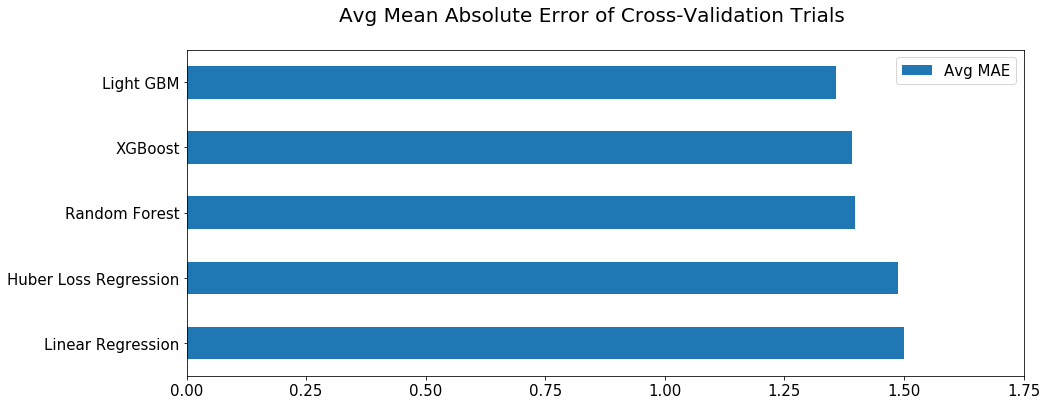

In [17]:
fig, ax = plt.subplots(figsize=(15, 6))
Scoring_df.plot(kind='barh', ax = ax)
ax.tick_params(labelsize=15)
plt.xticks(np.arange(0, 2, step=0.25))
ax.legend( prop={'size': 15})
A = fig.suptitle('Avg Mean Absolute Error of Cross-Validation Trials', fontsize=20)

The **Light Gradient Boosted Model** creates the lowest Mean Absolute Error, so I will choose this as my baseline model moving forward [(reference)](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)

# Residuals and Results

As we can see below, since the distribution of output variable (Separation) is so right skewed it is causing the distribution of our residuals to be skewed as well. In Linear Regression, one of the assumptions we make for our model to be valid is that the residuals are normally distributed. In this case, since the Mean Absolute Error for the Light Gradient Boosted model was the lowest (best), we do not need these assumptions to hold, as this is no longer linear regression.

For reference, LGBM is a fast, high-performance gradient boosting framework based on decision tree algorithms.[(more info)](https://lightgbm.readthedocs.io/en/latest/)

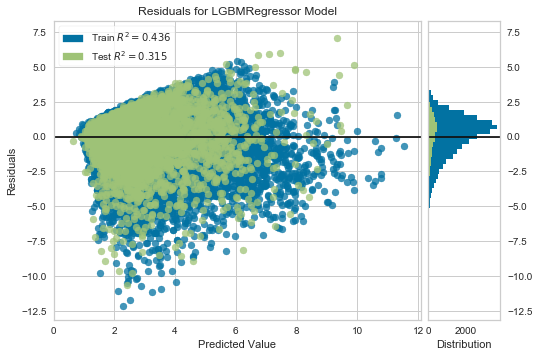

In [13]:
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from yellowbrick.model_selection import ValidationCurve


LGBM_fit = LGBM.fit(X_train_2, y_train_2)

visualizer = ResidualsPlot(LGBM_fit)
visualizer.fit(X_train_2, y_train_2)
visualizer.score(X_val, (y_val))
A = visualizer.show()

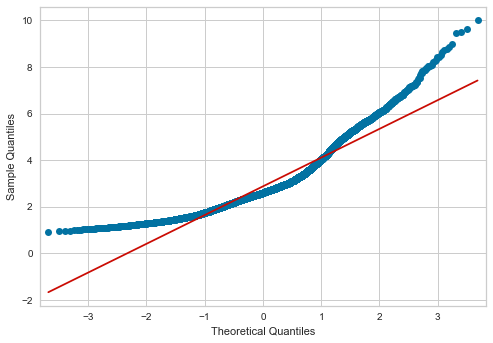

In [14]:
#QQ plot to show distribution of residuals
import statsmodels.api as sm

LGBM_fit.fit(X_train_2, y_train_2)
y_hat = LGBM_fit.predict(X_test)

# Create QQ plot
sm.qqplot(y_hat, line='s')
plt.show()


## Hyperparameter Tuning the Light Gradient Boosted Model

Below I use a library called [optuna](https://github.com/optuna/optuna) that helps with automatically hyperparameter tuning various ML models. As per suggestion on the documentation, it appears as though the 'num_leaves','min_data_in_leaf', and 'max_depth' are the most importand variables to tune, so I started here. With more time and resources, I would use more variants of other paramters to help with tuning. 

   1. **num_leaves:** describes the number of splits in the decision tree, higher is more accurate, but tends to lead to over fitting
   2. **min_data_in_leaf:** helps prevent overfitting, setting it to a large value can avoid growing too deep a tree, but may cause under-fitting.
   3. **max_depth:** is an explicit way to limit the tree depth

In [ ]:
import optuna
import optuna.integration.lightgbm as lgb

    
def objective(trial):
    
    
    dtrain = lgb.Dataset(X_train_2, label=y_train_2)
    dval = lgb.Dataset(X_val, label=y_val)
 
    params = {
    'objective': 'regression',
    'metric': 'l1',
    'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0), #regularization parameter #1
    'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0), # regularization parameter #2
    'num_leaves': trial.suggest_int('num_leaves', 2, 256), 
    'min_data_in_leaf': trial.suggest_loguniform('min_data_in_leaf', 100, 1e5),
    'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
    'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
    'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
 
    gbm = lgb.train(
    params, dtrain, valid_sets=[dtrain, dval], verbose_eval=100, early_stopping_rounds=100,
)
    preds = gbm.predict(X_val)
    val_MAE = mean_absolute_error(y_val, preds)
    return val_MAE
 
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)
 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [ ]:
best_params = study.best_trial.params
best_params

In [27]:
best_params = {'lambda_l1': 4.722475131235458e-05,
 'lambda_l2': 0.016291485969325333,
 'num_leaves': 39,
 'feature_fraction': 0.5369993001217288,
 'bagging_fraction': 0.8571594416259969,
 'bagging_freq': 7,
 'min_child_samples': 85}

In [28]:
Final_LGBM = LGBMRegressor(*best_params)

In [26]:
Final_LGBM.fit(X_train_2, y_train_2)

LGBMRegressor()

## How does our model do on our test data?

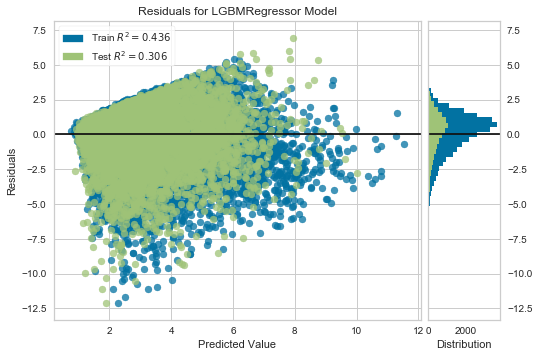

In [17]:
visualizer = ResidualsPlot(Final_LGBM)
visualizer.fit(X_train_2, y_train_2)
visualizer.score(X_test, (y_test))
A = visualizer.show()

In [18]:
y_test_hat = Final_LGBM.predict(X_test)
y_train_hat = Final_LGBM.predict(X_train_2)
test_MAE = mean_absolute_error(y_test, y_test_hat)
train_MAE = mean_absolute_error(y_train_2, y_train_hat)

print('The Training MAE was ' + str(train_MAE))
print('The Test MAE was ' + str(test_MAE))

The Training MAE was 1.2529431166179523
The Test MAE was 1.369109158088393


The mean absolute error of our test set is ~7% worse than that of out training set, but that is not terrible. It suggests that our model is *slightly overfit* to our training data, but for that sake of this project, I will not go any further in trying to lower the MAE of our test set.

In other ML modeling examples, however, I would take this feedback as an indicator that we have room to improve and would re-iterate on the model (feature engineering, hyperparameter tuning, feature selection) in order to create a more generalizable model that would perform at least as well, if not better, on the test set than the training set. 

In [19]:
LoadData = "../data/ExpSepPos.csv"
df = pd.read_csv(LoadData, index_col = False)


#Save output df to pkl file...
Final = processed.copy()
index = Final.index
Final = df.loc[index] 
Final['Pred_Sep'] = Final_LGBM.predict(X)

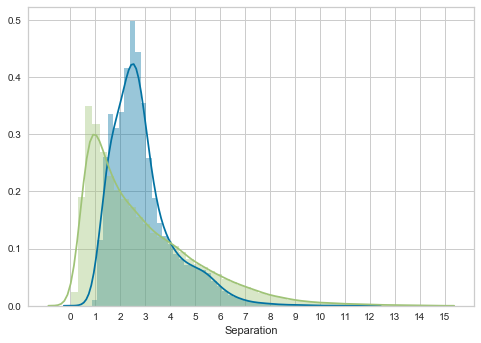

In [20]:
sns.distplot(Final['Pred_Sep'], kde_kws={'bw': .3})
sns.distplot(Final['Separation'], kde_kws={'bw': .3})
A =plt.xticks(range(-0, 16, 1))
# Add legend 

In [21]:
Final['Pred_Sep'].describe()

count    43559.000000
mean         2.886737
std          1.264920
min          0.638955
25%          2.023273
50%          2.605483
75%          3.362908
max         11.528270
Name: Pred_Sep, dtype: float64

In [22]:
Final['Separation'].describe()

count    43559.000000
mean         2.891849
std          2.206716
min          0.020000
25%          1.159871
50%          2.277982
75%          4.064400
max         14.472159
Name: Separation, dtype: float64

# Results!

In [23]:
%time
import shap
explainer = shap.TreeExplainer(Final_LGBM)
shap_values = explainer.shap_values(X)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


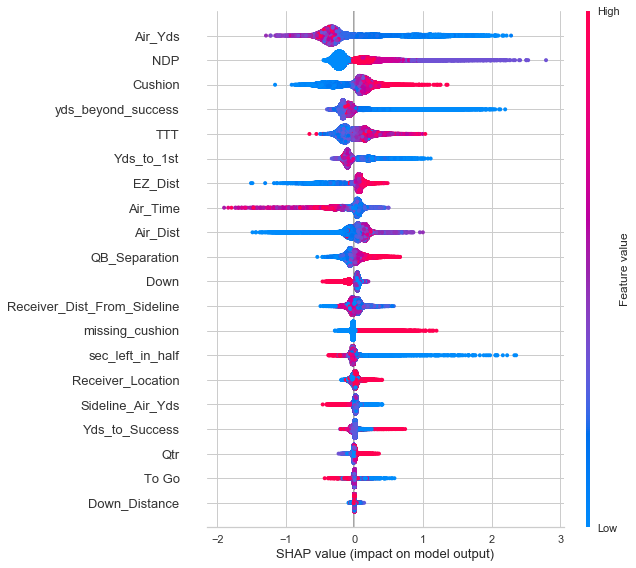

In [24]:
shap.summary_plot(shap_values, X)

The above [SHAP plot](https://github.com/slundberg/shap) gives an overview of how each feature contributed to the predicting separation on the whole. The Features (y-axis) are ordered by how often they were of significance to the prediction, with the most influential feature (Air Yards) at the top. 

The points themselves show how the value of each feauture was used to create the predictions. For example, when Air Yards values are low (blue) we can see that the model predicts a higher Separation (which, thankfully, makes sense). 

# Can we simplify our model?

Now that we see which our most important features are, I want to try to simplify our model by reducing the feature space. This will allow our model to be more generalizable, interpretable, and can potentially improve performance.

After sifting though dozens of different iterations of possible feature spaces, the following 6 features did the best job of miximizing error while minimizing the number of features.

   1. **Yds_Beyond_Success**
       - The vertical distance beyond the yardage deemed to be a successful play for the offense
           - Play success is defined in Feature Analysis and Engineer, and is based on down and distance
       - Though Air_Yds was most impactful feature when using *all* our features, 'Yds_beyond_success' was the most helpful in predictions in smaller feature spaces
   2. **Cushion**
       - The distance (in yds) from the defender lined up across from the targeted receiver at the time of ball snap
   3. **NDP**
       - A categorical feature with this mapping {Cornerbacks:0, Safeties+DBs:1, Linebackers:2, Defenseive Linemen:3}
   4. **Air Time**
       - The time (in seconds) it takes for a pass to travel in the air from launch to when it reaches the targeted recevier
   5. **Endzone Distance**
       - The distance (in yds) from where the recevier is targeted to the back of the endzone in the direction the team is facing

In [54]:
Selected_Cols = ['yds_beyond_success', 'Cushion' , 'NDP', 'Air_Time', 'EZ_Dist']

X = FeatEng.copy()[Selected_Cols]
y = FeatEng.copy()['Separation']

#take note of features that need scaling:
float_cols = X.select_dtypes(include=['float64'])
float_cols = float_cols.columns

#Split data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state) 

# Scale Continuous independent variables (input features)
Scaler = StandardScaler()

#Fit scaler to Training Set
Fit = Scaler.fit(X_train[float_cols])

#Scale the continuous features for all the data, Full set, Training set, and Test set
X_train[float_cols] = Fit.transform(X_train[float_cols])
X_test[float_cols] = Fit.transform(X_test[float_cols])
X[float_cols] = Fit.transform(X[float_cols])

#Split Train Data into Train_2 and Validation
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state = random_state)

#How big are the data sets?
X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_2.shape, X_val.shape, y_train_2.shape, y_val.shape

((34847, 5),
 (8712, 5),
 (34847,),
 (8712,),
 (30491, 5),
 (4356, 5),
 (30491,),
 (4356,))

In [55]:
%%time
#Linear Regression
LR_scores = CV_MAE(LR, X_train_2, y_train_2)
print('Mean Absolute Error %2f' %(-1 * LR_scores.mean()))

Mean Absolute Error -1.550164
CPU times: user 234 ms, sys: 23.5 ms, total: 257 ms
Wall time: 111 ms


In [56]:
%%time
#Light Gradient Boosted Model
LGBM_scores = CV_MAE(LGBM, X_train_2, y_train_2)
print('Mean Absolute Error %2f' %(-1 * LGBM_scores.mean()))

Final_LGBM = LGBM.fit(X_train_2, y_train_2)

Mean Absolute Error -1.424386
CPU times: user 6.9 s, sys: 248 ms, total: 7.14 s
Wall time: 2.02 s


In [57]:
y_test_hat = Final_LGBM.predict(X_test)
y_train_hat = Final_LGBM.predict(X_train_2)
test_MAE = mean_absolute_error(y_test, y_test_hat)
train_MAE = mean_absolute_error(y_train_2, y_train_hat)

print('The Training MAE was ' + str(train_MAE))
print('The Test MAE was ' + str(test_MAE))

The Training MAE was 1.3539997627330085
The Test MAE was 1.4365018309212854


The Test Error from using all of our features was 1.37 yards, while the test error from using these 5 specific features is 1.44 yards. This 0.07 difference in error accounts for a **5% loss** in accuracy. Considering the goal of this project is not to create exactly precise predictions, but rather to capture most of what goes into predicting receiver separation, I beleive this is reasonable solution for our final model.

In [58]:
%time 
explainer = shap.TreeExplainer(Final_LGBM)
shap_values = explainer.shap_values(X)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs


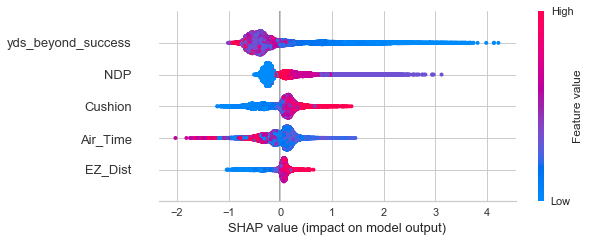

In [59]:
shap.summary_plot(shap_values, X)

In [60]:
#Save output df to pkl file...
Final = FeatEng.copy()
index = Final.index
Final = df.loc[index] 
Final['Pred_Sep'] = Final_LGBM.predict(X)

Final.to_pickle("../data/Final_5.pkl")

In [61]:
orig_df = pd.read_pickle("../data/OrdinalEnc.pkl")
Display = orig_df.copy().drop('Separation', axis = 1)
Display[float_cols] = Display[float_cols].round(2)
Display = Display[Selected_Cols]

## How does the model work?

Below are two contrasting examples that show how the features are combined to create the predictions.

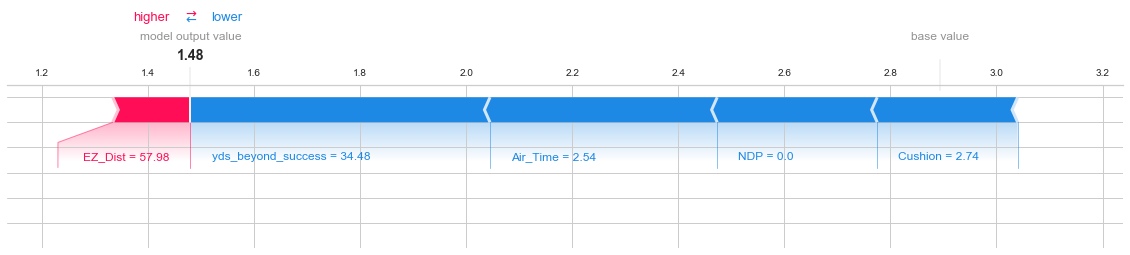

In [62]:
play = 5

shap.force_plot(explainer.expected_value, shap_values[play,:], Display.iloc[play,:], matplotlib = True)

In [63]:
#Actual Separation - Not Bad!
Final.iloc[5,:]['Separation']

1.281327486

On the above play, the model predicted that the player would have a **separation of 1.5 yards**, 1.4 yards less than the baseline prediction of ~2.9 yards. 

On this play the pass traveled 35 yards *beyond* the marker for a successful play, it was in the air for 2.5 seconds, and the receiver was defended by a CB at the time the pass arrived (NDP = 0), all factors that would lead us to believe it would have a smaller separation. 

On the play, the player had an **actual separation of 1.3 yards**. Not bad!

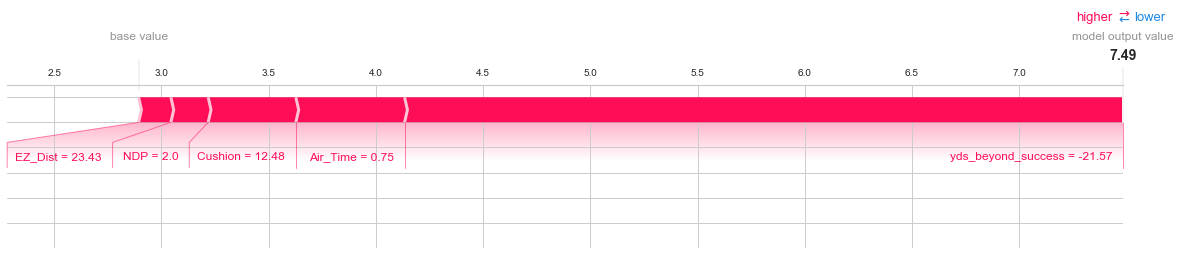

In [64]:
play = 59


shap.force_plot(explainer.expected_value, shap_values[play,:], Display.iloc[play,:], matplotlib = True)

In [65]:
#Actual Separation - Also looks good!
Final.iloc[59,:]['Separation']

6.668320656000001

On this play, the model said that the player would have a **predicted separation of 7.5 yards**, +5.0 yards greater than the baseline of 2.9 yards. 

This was due mostly to the fact that the pass targeted a receiver that was 22 yards *behind* what was considered a success on the play (most likely a screen pass). The receiver also had a massive 12.5 yards of pre-snap cushion and was defended by a LB (NDP = 2) as the nearest defender when the pass arrived. 

On the play, the player had an **actual separation of 6.7 yards**. Excellent!